<a target="_blank" href="https://colab.research.google.com/github/retowuest/uib-dl-2024/blob/main/nb-1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Learning for Social Scientists

### PhD Course, University of Bergen

## Table of Contents
* [1D Linear Regression](#section_1)
    * [Model Fitting With `scikit-learn`](#section_1_1)
    * [Model Fitting With Gradient Descent](#section_1_2)

## 1D Linear Regression <a class="anchor" id="section_1"></a>

The 1D linear regression model describes the relationship between input $x$ and output $y$ as a straight line,
$$
\begin{split}
y &= f[x, \boldsymbol{\phi}] \\
&= \phi_{0} + \phi_{1}x.
\end{split}
$$

The model parameters are $\boldsymbol{\phi} = [\phi_{0}, \phi_{1}]^{T}$.

Our goal is to choose parameters $\hat{\boldsymbol{\phi}}$ that map input $x$ to output $y$ as closely as possible on a training data set $\mathcal{S} = \{(x_{i}, y_{i})\}_{i = 1}^{N}$. We choose the mean squared error (MSE) as the loss function $L[\boldsymbol{\phi}]$ and find the parameter values that minimize $L[\boldsymbol{\phi}]$ on $\mathcal{S}$,
$$
\begin{split}
\hat{\boldsymbol{\phi}} &= \underset{\boldsymbol{\phi}}{\mathrm{argmin}}\big[L[\boldsymbol{\phi}]\big] \\
&= \underset{\boldsymbol{\phi}}{\mathrm{argmin}}\Bigg[\frac{1}{N}\sum_{i = 1}^{N}(f[x_{i}, \boldsymbol{\phi}] - y_{i})^{2}\Bigg] \\
&= \underset{\boldsymbol{\phi}}{\mathrm{argmin}}\Bigg[\frac{1}{N}\sum_{i = 1}^{N}(\phi_{0} + \phi_{1}x_{i} - y_{i})^{2}\Bigg].
\end{split}
$$

### Training Data

For this example, we will use the Ames Housing data set. This data set contains information about individual residential property in Ames, Iowa, from 2006 to 2010 [(De Cock 2011)](https://jse.amstat.org/v19n3/decock.pdf). Information about the data set is available via the following links:
- [Article](https://jse.amstat.org/v19n3/decock.pdf) describing the data set.
- [Documentation](https://jse.amstat.org/v19n3/decock/DataDocumentation.txt) of the data set's features.
- [Data set](http://jse.amstat.org/v19n3/decock/AmesHousing.txt) in tab-separated format.

The data set includes 2,930 examples and 80 features. The features we will be working with are the following:

- `Overall Qual`: Rating for the overall quality of material and finish of the house on a scale from 1 (very poor) to 10 (excellent).
- `Overall Cond`: Rating for the overall condition of the house on a scale from 1 (very poor) to 10 (excellent).
- `Gr Liv Area`: Above grade (ground) living area in square feet.
- `Central Air`: Central air conditioning (N=no, Y=yes).
- `Total Bsmt SF`: Total square feet of the basement area.
- `SalePrice`: Sale price in US dollars.

Our output is `SalePrice`. This is the variable we want to predict based on some input.

We will now load the Ames Housing data set using the `read_csv()` function from the `pandas` library.

In [2]:
# Import library
import pandas as pd

# Specify list with names of feature we want to use
columns = ["Overall Qual", "Overall Cond", "Gr Liv Area",
           "Central Air", "Total Bsmt SF", "SalePrice"]

# Load data set
ames_df = pd.read_csv("http://jse.amstat.org/v19n3/decock/AmesHousing.txt",
                      sep="\t",
                      usecols=columns)

# Print dimensions of dataframe
print("Dimensions of dataframe:", ames_df.shape)

# Print first few rows of dataframe
ames_df.head()

Dimensions of dataframe: (2930, 6)


,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


The variable `Central Air` is encoded as type `string` with values `Y` and `N`. We can use the `.map` method to convert it to an integer variable with values `1` (for `Y`) and `0` (for `N`).

In [5]:
# Convert column `Central Air` to integer
ames_df["Central Air"] = ames_df["Central Air"].map({"N": 0, "Y": 1})

# Print first few rows of dataframe
ames_df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,1,1656,215000
1,5,6,882.0,1,896,105000
2,6,6,1329.0,1,1329,172000
3,7,5,2110.0,1,2110,244000
4,5,5,928.0,1,1629,189900


Let's now check whether any of the dataframe columns contain missing values.

In [11]:
# Count missing value by column
ames_df.isnull().sum(axis=0)

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

We remove from the dataframe the example with a missing value in feature `Total Bsmt SF`.

In [20]:
# Drop examples (rows) with missing values
ames_df = ames_df.dropna(axis=0)

# Count missing value by column
ames_df.isnull().sum(axis=0)

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

We typically perform some exploratory data analysis (EDA) before training a model. This important step helps us better understand the data (e.g., learn about the distribution of the data, the relationships between features, and the presence of outliers).

Here, we will use the `scatterplotmatrix` function from the `mlxtend` library to create a scatterplot matrix that allows us to visualize the pairwise correlations between the features in the dataframe.

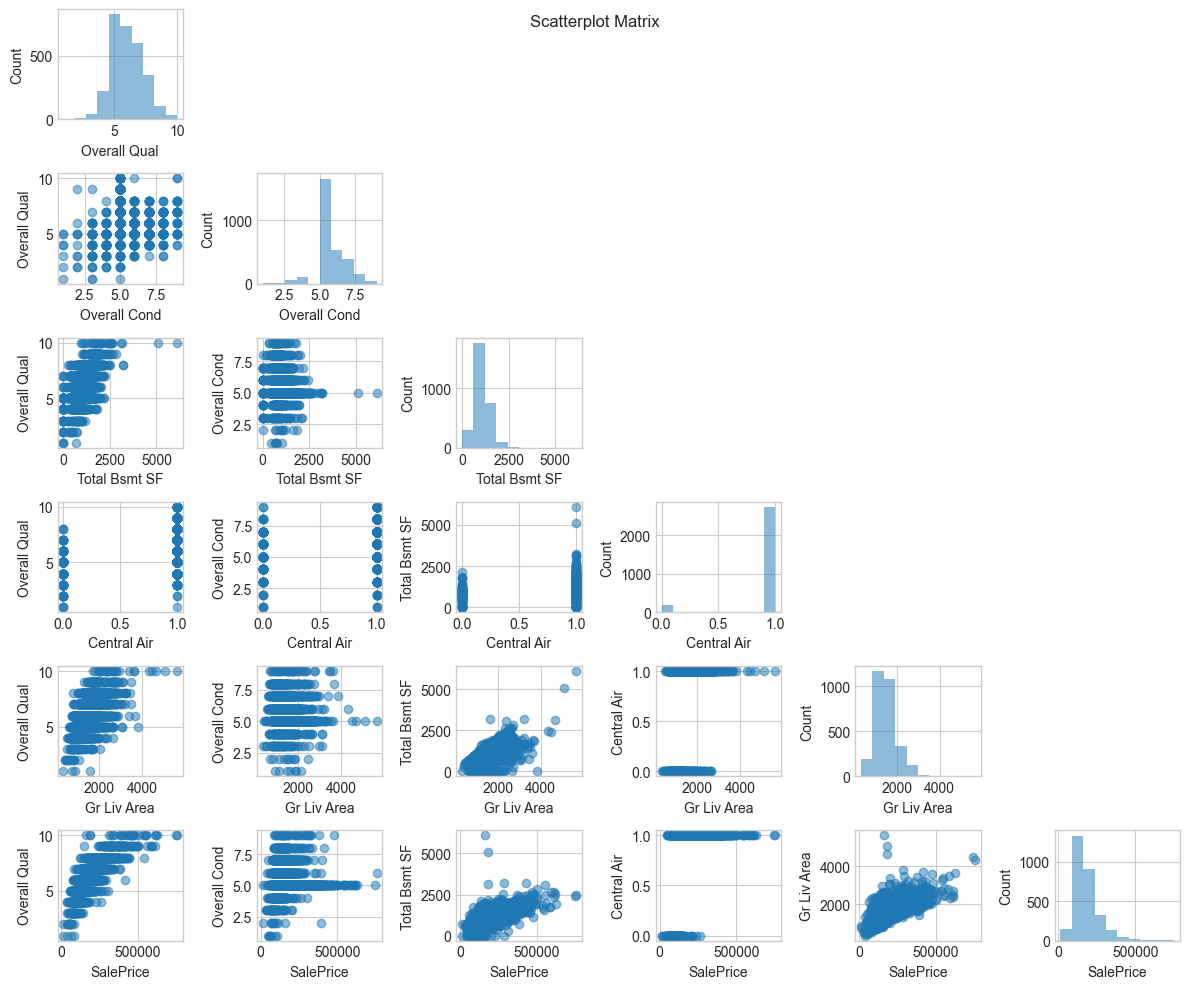

In [115]:
# Import pyplot module from the matplotlib library and
# the scatterplotmatrix function from the mlxtend library
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

# Set up notebook for displaying plots
%matplotlib inline

# Create scatterplot matrix
scatterplotmatrix(ames_df.values, figsize=(12, 10),
                  names=ames_df.columns, alpha=0.5)
plt.tight_layout()
plt.suptitle("Scatterplot Matrix")
plt.show();

There is a clear linear relationship between `SalePrice` and `Gr Liv Area`. We therefore use the feature `Gr Liv Area` as the input to predict the output `SalePrice` in our 1D linear regression model.

In [35]:
# Extract input and output from the dataframe
X = ames_df[["Gr Liv Area"]].values
y = ames_df["SalePrice"].values

### Model Fitting With `scikit-learn` <a class="anchor" id="section_1_1"></a>

Let's fit the 1D linear regression model with `scikit-learn`.

In [123]:
# Import LinearRegression class from the linear_model module
# in the scikit-learn library
from sklearn.linear_model import LinearRegression

# Create instance of class LinearRegression
lr_skl = LinearRegression()

# Train model on training data
lr_skl.fit(X, y)

# Print fitted model parameters
print(f"Intercept: {lr_skl.coef_[0]:.3f}")
print(f"Slope: {lr_skl.intercept_:.3f}")

Intercept: 111.666
Slope: 13342.979


We can also plot the training data together with the fitted regression line.

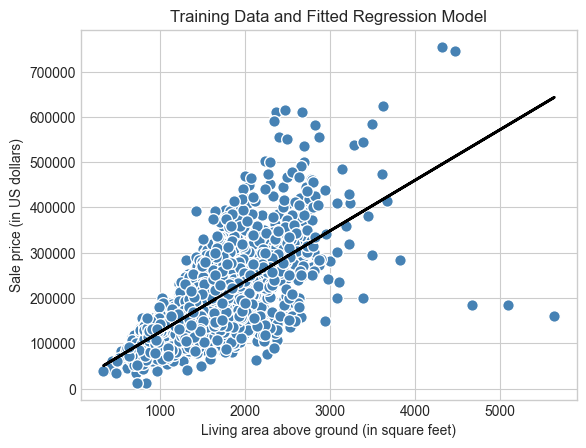

In [124]:
# Plot training data together with fitted regression line
plt.scatter(X, y, c="steelblue", edgecolor="white", s=70)
plt.plot(X, lr_skl.predict(X), color="black", lw=2)
plt.xlabel("Living area above ground (in square feet)")
plt.ylabel("Sale price (in US dollars)")
plt.title("Training Data and Fitted Regression Model")
plt.show();

### Model Fitting With Gradient Descent <a class="anchor" id="section_1_2"></a>

We will take an object-oriented programming (OOP) approach and implement the gradient descent algorithm as a [Python class](https://realpython.com/python-classes/).

In [27]:
# Import numpy library
import numpy as np

In [99]:
# Implement gradient descent algorithm
class LinearRegressionGD:
    def __init__(self, alpha=0.01, n_iter=50, random_state=1):
        self.alpha = alpha
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.phi_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.phi0_ = np.array([0.])
        self.losses_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (output - y)
            self.phi_ -= self.alpha * 2.0 * X.T.dot(errors) / X.shape[0]
            self.phi0_ -= self.alpha * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self
    
    def net_input(self, X):
        return self.phi0_ + np.dot(X, self.phi_)
    
    def predict(self, X):
        return self.net_input(X)

Before we train the gradient descent algorithm on our training data, we will standardize the variables for better convergence of the algorithm.

In [100]:
# Import StandardScaler class from the preprocessing module
# in the scikit-learn library
from sklearn.preprocessing import StandardScaler

# Initialize two StandardScaler objects
sc_x = StandardScaler()
sc_y = StandardScaler()

# For each feature, learn sample mean and sd from training data (fit method)
# and use these values to standardize it (z-score) (transform method)
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

Let's now train our gradient descent algorithm on the standardized training data.

In [101]:
# Instantiate class LinearRegressionGD
lr_gd = LinearRegressionGD(alpha=0.1)

# Train model on standardized training data
lr_gd.fit(X_std, y_std)

To check whether the gradient descent algorithm converged to the global minimum of the loss function, we plot the loss by epoch (iteration) over the training data set. As we can see, the algorithm converged approximately after the 10th epoch.

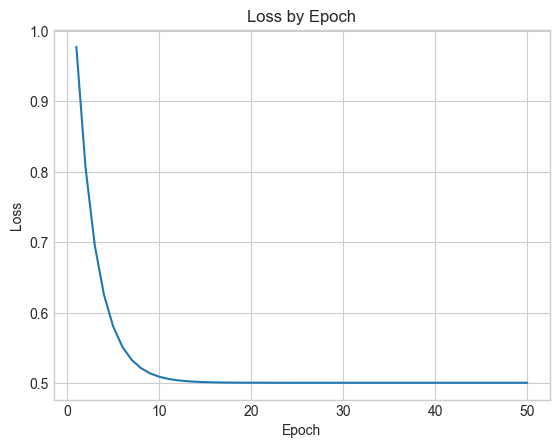

In [109]:
# Plot loss by epoch
plt.plot(range(1, lr_gd.n_iter + 1), lr_gd.losses_)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss by Epoch")
plt.show()

Finally, we can print the fitted parameters of the 1D linear regression model and plot the training data together with the regression line.

Intercept: -0.000
Slope: 0.707


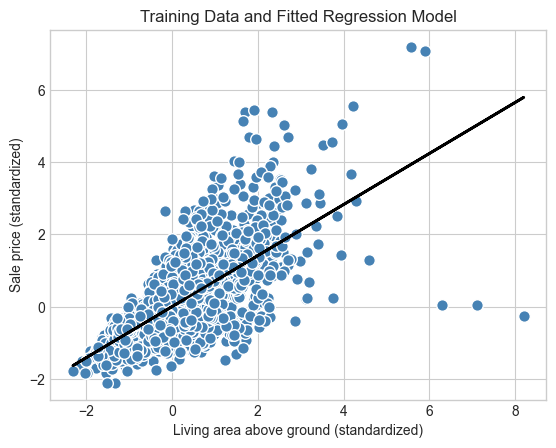

In [110]:
# Print fitted model parameters
print(f"Intercept: {lr_gd.phi0_[0]:.3f}")
print(f"Slope: {lr_gd.phi_[0]:.3f}")

# Plot training data together with fitted regression line
plt.scatter(X_std, y_std, c="steelblue", edgecolor="white", s=70)
plt.plot(X_std, lr_gd.predict(X_std), color="black", lw=2)
plt.xlabel("Living area above ground (standardized)")
plt.ylabel("Sale price (standardized)")
plt.title("Training Data and Fitted Regression Model")
plt.show();